<a href="https://colab.research.google.com/github/ShutSV/data-science/blob/main/%D0%92%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B9_%D0%B0%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Вариационный автоэнкодер для генерации изображений лиц

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# определение пути для загрузки изображений из папки google drive
data_path = '/content/drive/MyDrive/Colab_Notebooks/face'

#Просмотр некторых исходных изображений

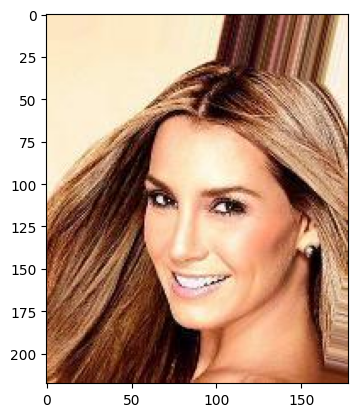

In [28]:
import matplotlib.pyplot as plt

img01 = plt.imread('/content/drive/MyDrive/Colab_Notebooks/face/face/000001.jpg')
img02 = plt.imread('/content/drive/MyDrive/Colab_Notebooks/face/face/000002.jpg')
img03 = plt.imread('/content/drive/MyDrive/Colab_Notebooks/face/face/000003.jpg')
img100 = plt.imread('/content/drive/MyDrive/Colab_Notebooks/face/face/000100.jpg')
img700 = plt.imread('/content/drive/MyDrive/Colab_Notebooks/face/face/000700.jpg')
plt.imshow(img01)

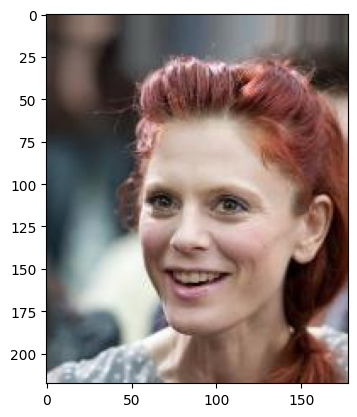

In [16]:
plt.imshow(img02)

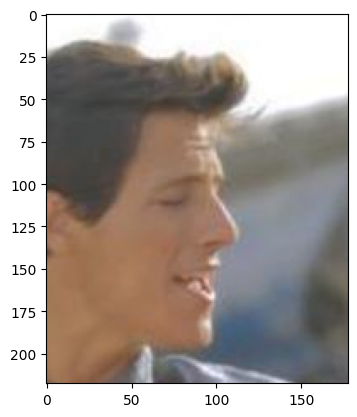

In [18]:
plt.imshow(img03)

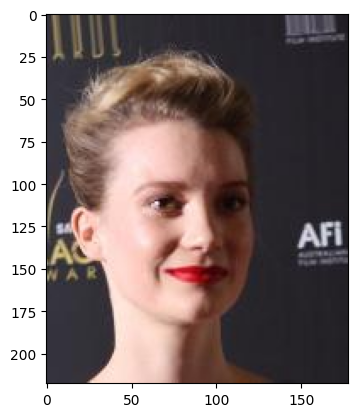

In [19]:
plt.imshow(img100)

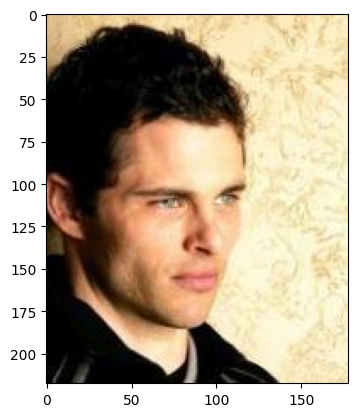

In [29]:
plt.imshow(img700)

In [4]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Определение модели VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(116412, 400)
        self.fc21 = nn.Linear(400, 20)  # mu
        self.fc22 = nn.Linear(400, 20)  # logvar
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 116412)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 116412))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Функция потерь
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 116412), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Параметры
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 50

# Загрузка данных
# Предполагается, что изображения уже предобработаны и имеют одномерную размерность (например, 3072 = 3x32x32)
transform = transforms.Compose([
    transforms.Resize((218, 178)),  # Изменение размера изображения до 32x32 пикселей
    transforms.ToTensor(),  # Преобразование изображения в тензор PyTorch
])

# Укажите 'root' путь к папке, содержащей подпапки с изображениями каждого класса
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Создание DataLoader для загрузки данных
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)


# Инициализация модели, оптимизатора
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Обучение
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

# Генерация изображений
with torch.no_grad():
    sample = torch.randn(64, 20).to(device)
    sample = model.decode(sample).cpu()
    save_image(sample.view(64, 3, 218, 178), 'sample.png')

Epoch 0, Loss: 162389.3156596794
Epoch 1, Loss: 12908352185.704685
Epoch 2, Loss: 87056.36282367447
Epoch 3, Loss: 81829.26171393342
Epoch 4, Loss: 80405.130702836
Epoch 5, Loss: 79895.19451294698
Epoch 6, Loss: 79614.59864364982
Epoch 7, Loss: 79416.24290998768
Epoch 8, Loss: 79303.05702836005
Epoch 9, Loss: 79045.05826140568
Epoch 10, Loss: 78736.62577065351
Epoch 11, Loss: 78943.0650431566
Epoch 12, Loss: 79153.50493218249
Epoch 13, Loss: 78962.43865598027
Epoch 14, Loss: 79586.62946979038
Epoch 15, Loss: 80152.28452527744
Epoch 16, Loss: 80442.81226880394
Epoch 17, Loss: 79262.5329839704
Epoch 18, Loss: 80419.16769420469
Epoch 19, Loss: 79267.48427866831
Epoch 20, Loss: 79479.36128236745
Epoch 21, Loss: 79443.21979038224
Epoch 22, Loss: 78676.83754623921
Epoch 23, Loss: 77544.00924784217
Epoch 24, Loss: 78671.1627620222
Epoch 25, Loss: 80366.16430332922
Epoch 26, Loss: 78724.94759556104
Epoch 27, Loss: 79543.38378545006
Epoch 28, Loss: 80877.31442663379
Epoch 29, Loss: 80143.382244

In [10]:
# Генерация изображений
with torch.no_grad():
    sample = torch.randn(4, 20).to(device)
    sample = model.decode(sample).cpu()
    save_image(sample.view(4, 3, 218, 178), '/content/drive/MyDrive/Colab_Notebooks/sample2.png')

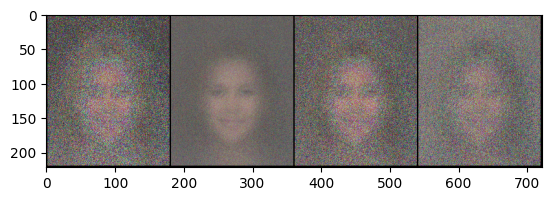

In [12]:
import matplotlib.pyplot as plt

img = plt.imread('/content/drive/MyDrive/Colab_Notebooks/sample2.png')
plt.imshow(img)